# Forecasting Bike Sharing Demand

## 1. Project Goal

The objective of this project is to build and evaluate time series forecasting models to predict the daily demand for shared bikes. This project follows a comprehensive Exploratory Data Analysis (EDA) where we identified strong trends and multiple seasonal patterns (yearly and weekly).

This notebook will focus on:
1.  Preparing and aggregating the hourly data into a daily time series.
2.  Decomposing the time series to formally analyze its components.
3.  Building a classic statistical model (SARIMA) as a baseline.
4.  Building a modern forecasting model (Prophet) that can handle multiple seasonalities and external regressors (weather).
5.  Evaluating and comparing the models to generate a final forecast.

## 2. The Dataset
We will be using the hourly bike sharing data from the Capital Bikeshare program in Washington D.C. (2011-2012).

*   **Source:** [Capital Bikeshare data from the UCI Machine Learning Repository, via Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset)

--- Daily Aggregated DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      731 non-null    datetime64[ns]
 1   cnt         731 non-null    int64         
 2   temp        731 non-null    float64       
 3   hum         731 non-null    float64       
 4   windspeed   731 non-null    float64       
 5   weathersit  731 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.4 KB


      dteday   cnt      temp       hum  windspeed  weathersit
0 2011-01-01   985  0.344167  0.805833   0.160446           1
1 2011-01-02   801  0.363478  0.696087   0.248539           2
2 2011-01-03  1349  0.196364  0.437273   0.248309           1
3 2011-01-04  1562  0.200000  0.590435   0.160296           1
4 2011-01-05  1600  0.226957  0.436957   0.186900           1


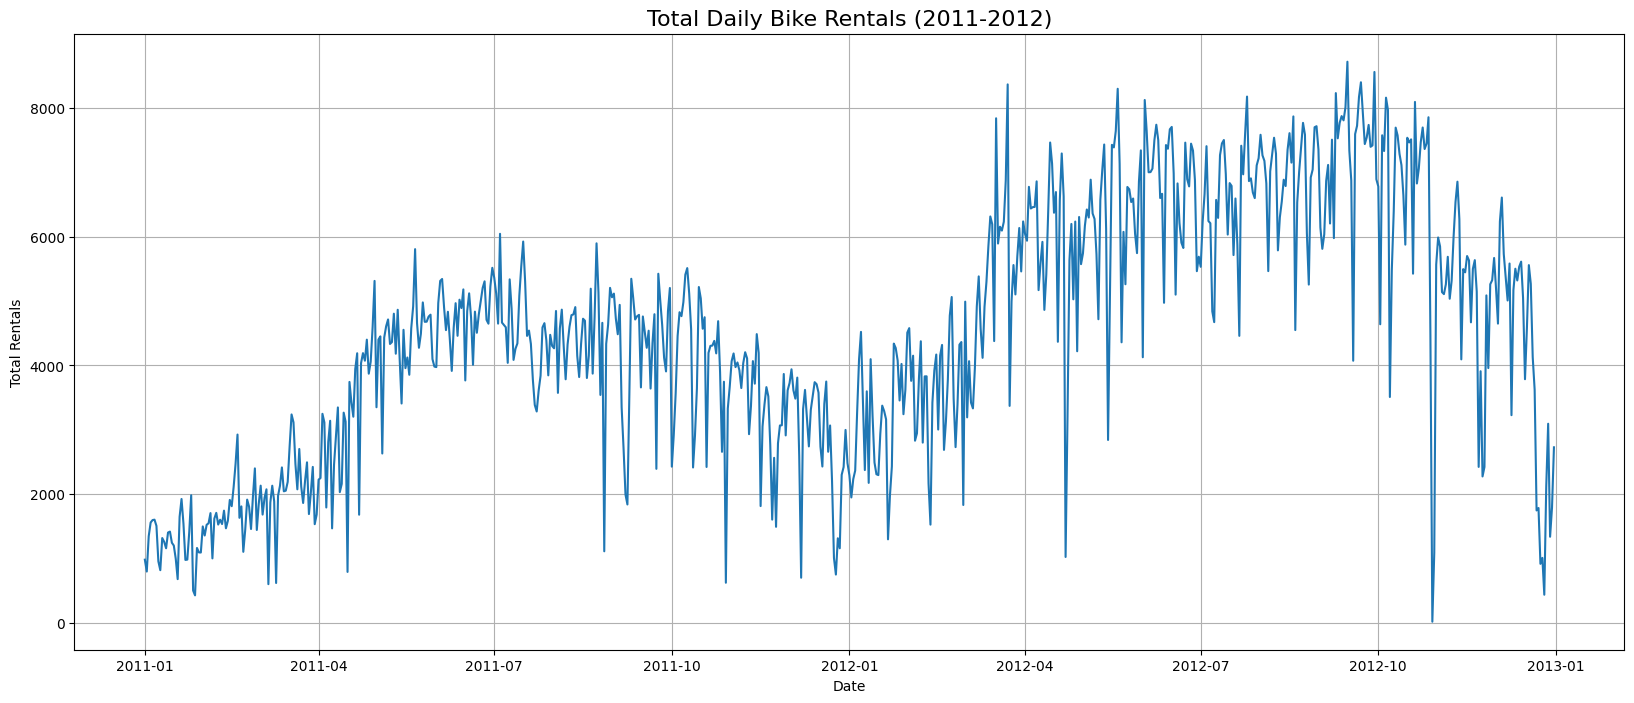

In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
# We will import other libraries like Prophet later as we need them.


# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# --- 2. LOAD HOURLY DATA ---
file_path = './data/hour.csv'
# Ensure dteday is parsed as a datetime object
df_hour = pd.read_csv(file_path, parse_dates=['dteday'])


# --- 3. AGGREGATE TO DAILY LEVEL ---
# This is the most crucial preparation step.

# Set 'dteday' as the index for easy resampling
df_hour.set_index('dteday', inplace=True)

# Define the aggregations for each column
aggregations = {
    'cnt': 'sum',          # Total daily count is the sum of hourly counts
    'temp': 'mean',        # Daily temperature is the average of hourly temps
    'hum': 'mean',         # Daily humidity is the average
    'windspeed': 'mean',   # Daily windspeed is the average
    'weathersit': 'first'  # We can take the first weather situation of the day as representative
}

# Resample to a daily ('D') frequency and apply the aggregations
df_daily = df_hour.resample('D').agg(aggregations).reset_index()


# --- 4. INITIAL EXPLORATION OF DAILY DATA ---
print("--- Daily Aggregated DataFrame ---")
df_daily.info()
print("\n")
print(df_daily.head())

# Plot the daily time series to see what we're working with
plt.figure(figsize=(20, 8))
plt.plot(df_daily['dteday'], df_daily['cnt'])
plt.title('Total Daily Bike Rentals (2011-2012)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.grid(True)
plt.show()

### 2.1 Data Aggregation: From Hourly to Daily

The raw dataset is provided at an hourly granularity. While this is excellent for analyzing intra-day patterns (as seen in our EDA), for the purpose of a daily forecasting model, we need to aggregate this data into a **daily time series**.

This was achieved by resampling the hourly data to a daily ('D') frequency. For each day, we calculated:
*   The **total** number of rentals by summing the hourly `cnt` values.
*   The **average** daily weather conditions by taking the mean of the hourly `temp`, `hum`, and `windspeed`.
*   A representative `weathersit` by taking the first recorded value for each day.

The resulting `df_daily` DataFrame contains 731 rows, one for each day in the 2011-2012 period, and serves as the foundation for our forecasting models. The plot above visualizes this daily time series, clearly showing both a year-over-year growth trend and strong seasonal patterns.
- The Upward Trend: We can clearly see that the general level of rentals in 2012 is much higher than in 2011. The program is growing.
- The Yearly Seasonality: Can see the distinct "hill" shape in both years—low in the winter, rising in the spring, peaking in the summer, and falling in the autumn.
- The Daily "Noise": The line is very jagged and spiky. This is the daily volatility. That "noise" contains the powerful weekly seasonality (the commuter vs. weekend pattern) that we will need to model.

## 3. Time Series Decomposition

Before building a forecasting model, it's crucial to understand the underlying structure of the time series. **Time series decomposition** is a statistical method that deconstructs the series into three components:

1.  **Trend:** The long-term progression of the series (e.g., is it growing or declining over the years?).
2.  **Seasonality:** The repeating, cyclical patterns within the series (e.g., yearly highs in summer, weekly patterns).
3.  **Residuals (or Noise):** The irregular, random component that is left over after the trend and seasonality have been removed.

By visualizing these components, we can formally confirm the patterns we observed visually and better understand the data's behavior. We will use an **additive decomposition model**, which assumes `Observed = Trend + Seasonal + Residual`.

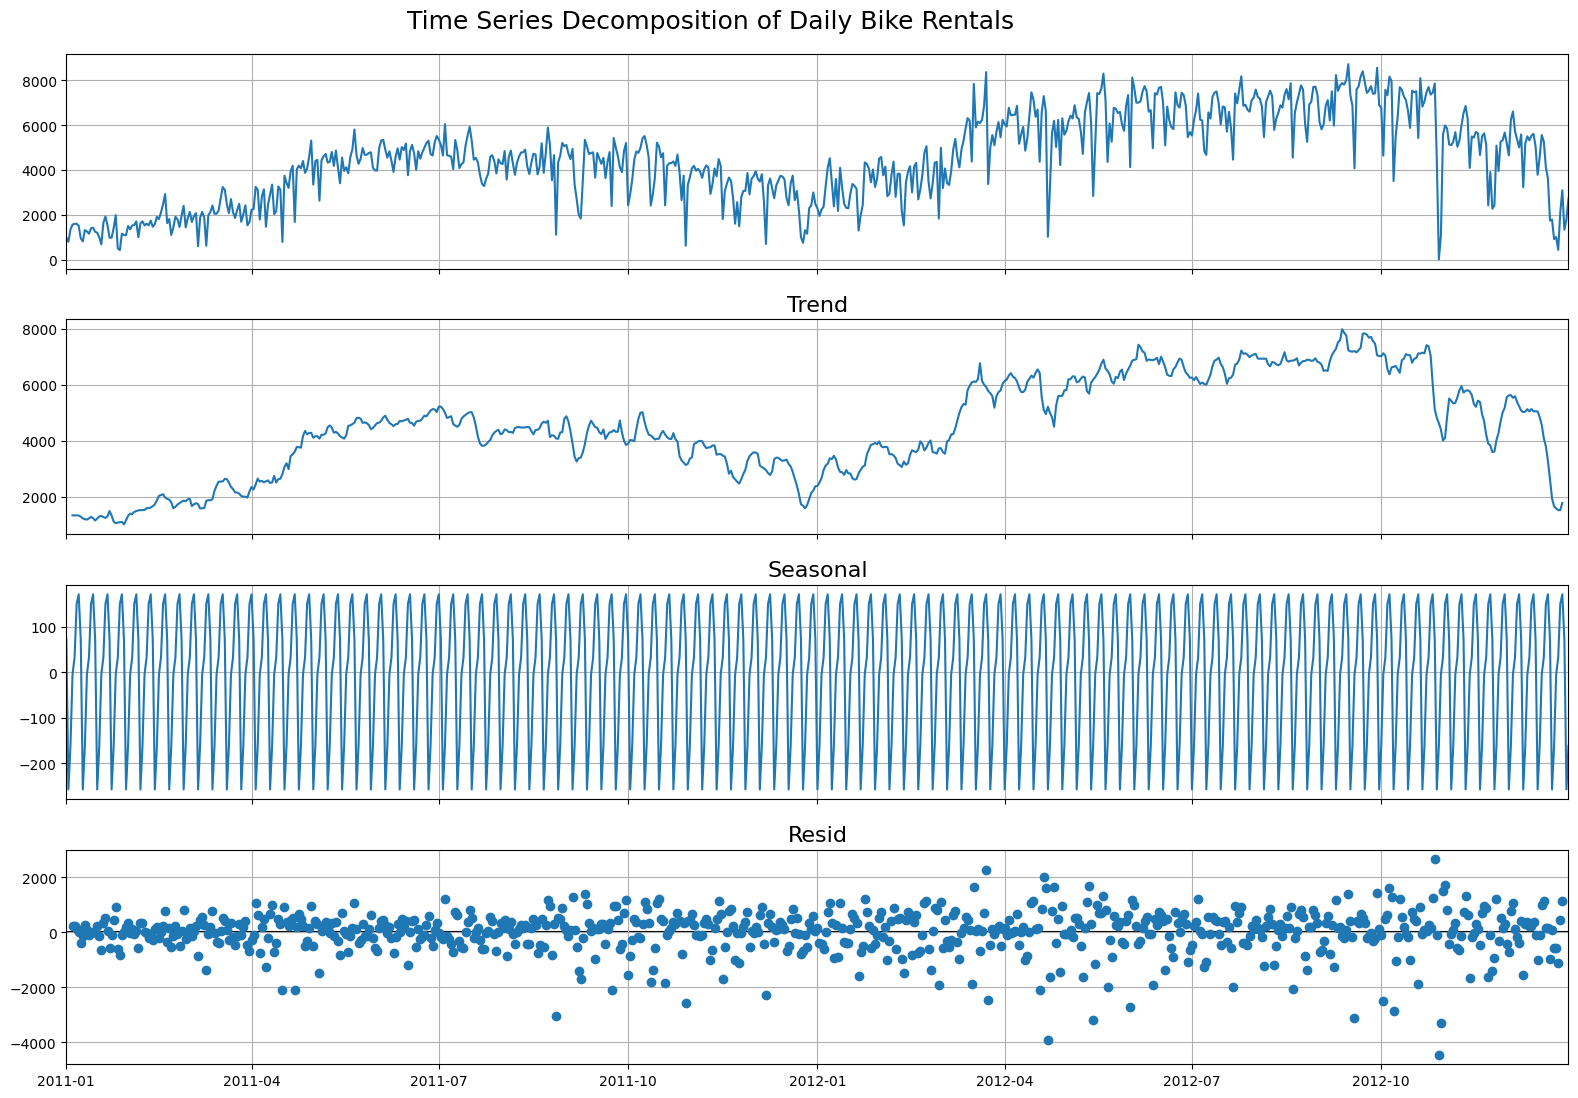

In [2]:
# --- 1. Set the date as the index (required for seasonal_decompose) ---
df_decomp = df_daily.set_index('dteday')

# --- 2. Perform the seasonal decomposition ---
# The 'period' is the number of observations in a full seasonal cycle.
# Since we have daily data and expect a strong weekly pattern, we'll set it to 7.
decomposition = seasonal_decompose(df_decomp['cnt'], model='additive', period=7)


# --- 3. Plot the decomposed components ---
fig = decomposition.plot()
fig.set_size_inches(18, 12)
fig.suptitle('Time Series Decomposition of Daily Bike Rentals', fontsize=18, y=0.96)

# Make the titles of the subplots more prominent
for ax in fig.axes:
    ax.set_title(ax.get_ylabel(), fontsize=16)
    ax.set_ylabel('') # Clear the y-label for a cleaner look
    ax.grid(True)


plt.show()

**Observations from the Decomposition Plot:**

The decomposition plot provides a clear, quantitative confirmation of the patterns in our data:

1.  **Trend:** The top plot shows the "Observed" data. The second plot, "Trend," smooths out the daily noise and reveals the underlying long-term movement. It clearly shows:
    *   An initial growth phase in early 2011.
    *   A stable plateau in mid-2011.
    *   A significant, sustained **upward trend** throughout 2012. This confirms the program's growing popularity.

2.  **Seasonal:** The third plot isolates the repeating weekly pattern. It shows a distinct and consistent cycle:
    *   Demand is **lowest on weekends (especially Sunday)**.
    *   Demand **peaks midweek (Wednesday, Thursday, Friday)**.
    This is the "commuter" pattern dominating the daily data, just as we saw in our EDA. Our forecasting model will need to be able to capture this strong weekly seasonality.

3.  **Residual:** The bottom plot shows the random, unpredictable component of the series. The residuals appear to be fairly random (no obvious patterns), which is a good sign. However, we can see some periods of higher volatility (larger spikes), especially around late 2012.

**Insight:**
This formal decomposition has proven that our time series is composed of a strong **upward trend** and a very strong **weekly seasonal pattern**. Any successful forecasting model, whether it's a classic statistical model like SARIMA or a modern one like Prophet, **must** be able to account for both of these components.

## 4. Preparing for Forecasting: Train-Test Split

To evaluate the performance of our forecasting models, we need to split our dataset into a training set and a testing set. Unlike in standard machine learning, this split must be **chronological**.

We will train our models on the historical data and then test their ability to accurately forecast the data points in the future. A common approach is to hold back the last few months of data for testing. We will use all of the 2011 data and the first 9 months of 2012 for training, and hold back the last 3 months of 2012 as our unseen test set.

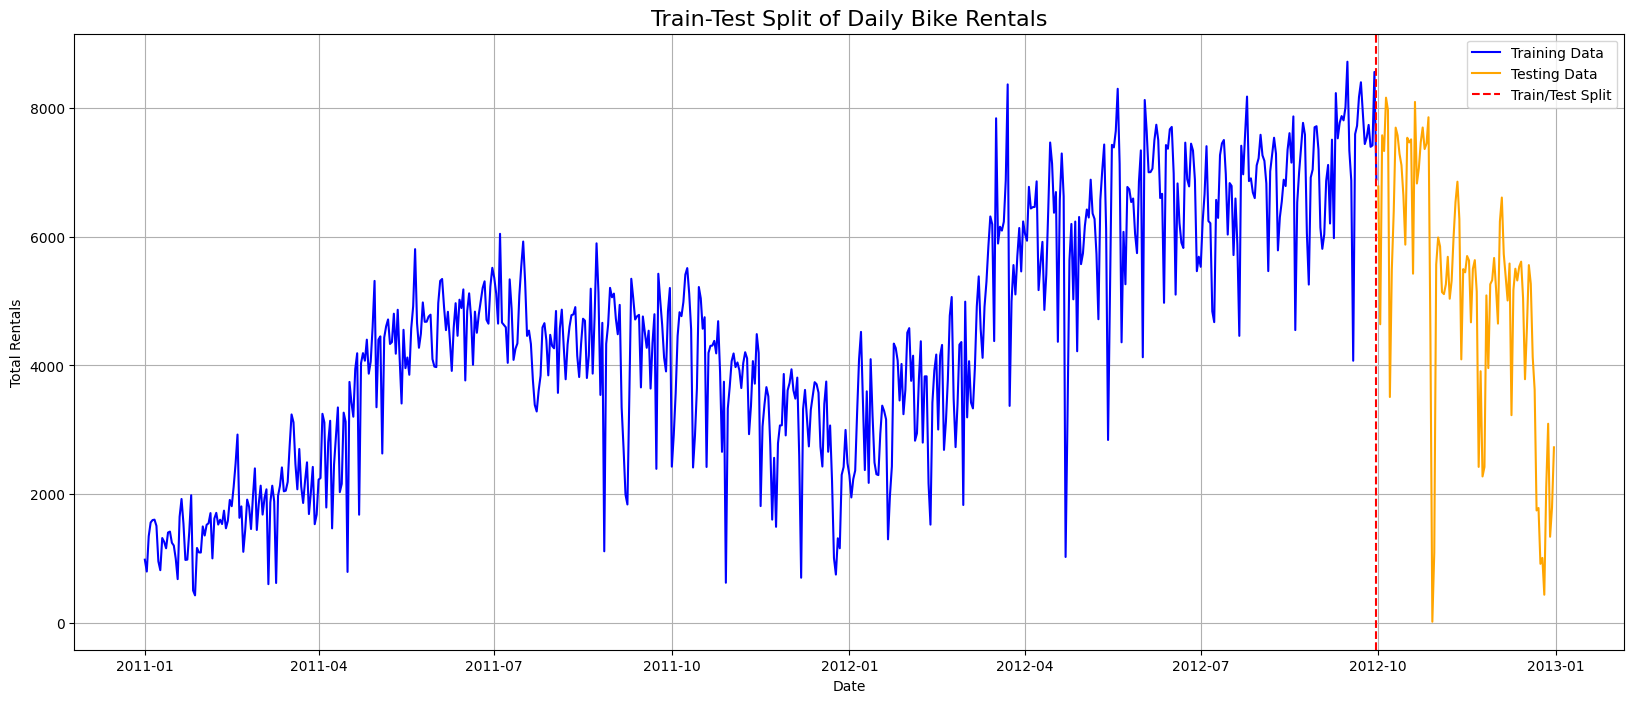

--- Data Split Verification ---
Training data shape: (639, 6)
Testing data shape:  (92, 6)
Training data from 2011-01-01 to 2012-09-30
Testing data from  2012-10-01 to 2012-12-31


In [3]:
# --- 1. Define the split point ---
# We'll set the split date to be the end of September 2012.
split_date = '2012-09-30'

# --- 2. Create the training and testing sets ---
df_train = df_daily[df_daily['dteday'] <= split_date].copy()
df_test = df_daily[df_daily['dteday'] > split_date].copy()


# --- 3. Visualize the split ---
# This is a crucial step to ensure our split is correct.
plt.figure(figsize=(20, 8))

# Plot the training data in blue
plt.plot(df_train['dteday'], df_train['cnt'], label='Training Data', color='blue')

# Plot the testing data in orange
plt.plot(df_test['dteday'], df_test['cnt'], label='Testing Data', color='orange')

# Add a vertical line at the split point for clarity
plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', label='Train/Test Split')

plt.title('Train-Test Split of Daily Bike Rentals', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.grid(True)
plt.show()

# --- 4. Verification ---
print("--- Data Split Verification ---")
print(f"Training data shape: {df_train.shape}")
print(f"Testing data shape:  {df_test.shape}")
print(f"Training data from {df_train['dteday'].min().date()} to {df_train['dteday'].max().date()}")
print(f"Testing data from  {df_test['dteday'].min().date()} to {df_test['dteday'].max().date()}")

## 5. Model 1: Baseline Forecast with SARIMA

Our first forecasting model will be the classic **SARIMA (Seasonal AutoRegressive Integrated Moving Average)**.

### 5.1 Finding SARIMA Parameters with ACF and PACF Plots

Unlike an automated search, the traditional method for finding the `p` and `q` parameters for a SARIMA model is to analyze the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots. These plots show the correlation of the time series with lagged versions of itself.

*   **ACF Plot:** Helps us determine the `q` (Moving Average) order.
*   **PACF Plot:** Helps us determine the `p` (AutoRegressive) order.

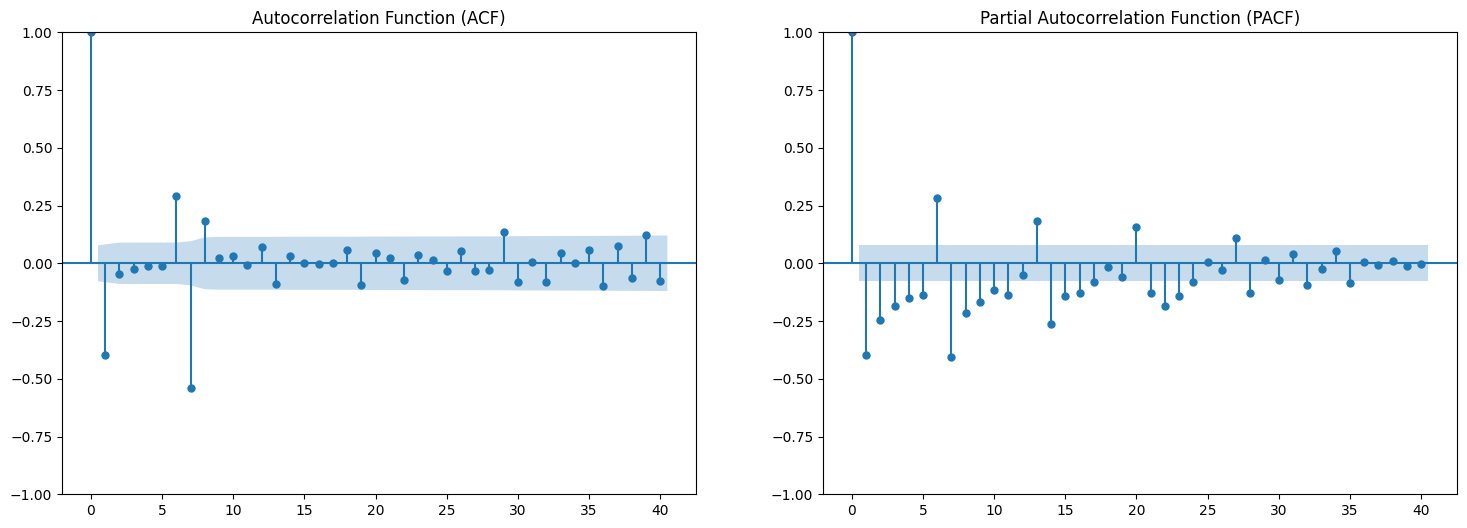

In [4]:
# Import the plotting functions from statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# We need to make the series stationary by differencing it once to remove the trend
# and once seasonally to remove the weekly pattern.
differenced_series = df_train['cnt'].diff(1).diff(7).dropna()

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot ACF
plot_acf(differenced_series, ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(differenced_series, ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

#### Observation
Based on the ACF/PACF plots, we will start with a reasonable set of parameters. A full hyperparameter search is possible but computationally intensive. Our goal here is to establish a strong baseline. We will use a SARIMAX model with an order of `(1,1,1)` and a seasonal order of `(1,1,1,7)`.

--- Fitting the SARIMAX model (this may take a minute)... ---
Model fitting complete.
                                     SARIMAX Results                                     
Dep. Variable:                               cnt   No. Observations:                  639
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5161.483
Date:                           Sat, 09 Aug 2025   AIC                          10332.966
Time:                                   19:19:53   BIC                          10355.202
Sample:                                        0   HQIC                         10341.602
                                           - 639                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2695      0.043    

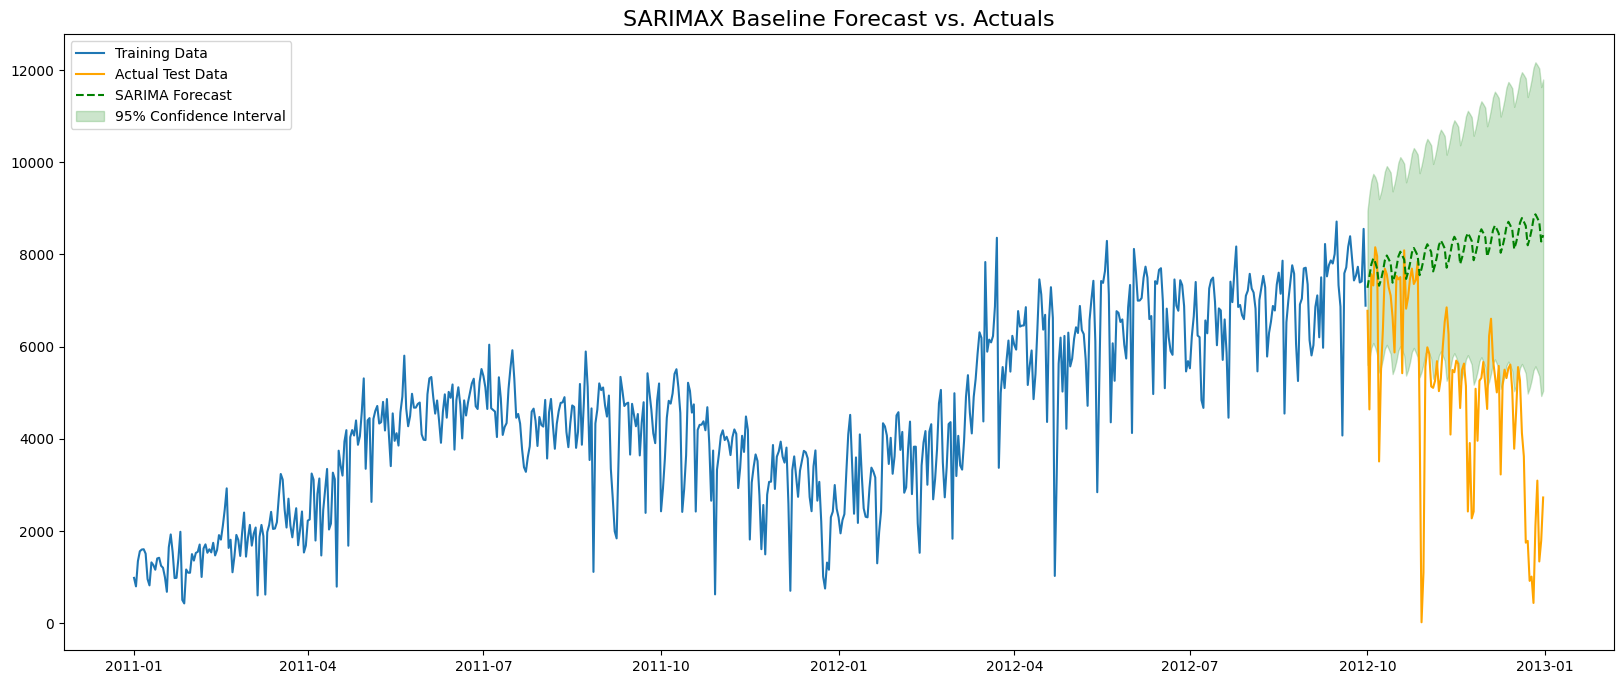

SARIMAX Model RMSE: 3625.99


In [5]:
# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- 1. Define and Fit the Model ---
# We use the training data
train_data = df_train['cnt']
# Define the model parameters
order = (1, 1, 1) # (p,d,q)
seasonal_order = (1, 1, 1, 7) # (P,D,Q,m)

print("--- Fitting the SARIMAX model (this may take a minute)... ---")
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False) # disp=False hides convergence output
print("Model fitting complete.")
print(results.summary())


# --- 2. Generate the Forecast ---
n_periods = len(df_test)
forecast = results.get_forecast(steps=n_periods)
forecast_df = forecast.summary_frame()


# --- 3. Visualize and Evaluate ---
plt.figure(figsize=(20, 8))
plt.plot(df_train['dteday'], df_train['cnt'], label='Training Data')
plt.plot(df_test['dteday'], df_test['cnt'], label='Actual Test Data', color='orange')
# Plot the forecast using the 'mean' column from the summary frame
plt.plot(df_test['dteday'], forecast_df['mean'], label='SARIMA Forecast', color='green', linestyle='--')
# Plot the confidence interval
plt.fill_between(df_test['dteday'], forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'],
                 color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('SARIMAX Baseline Forecast vs. Actuals', fontsize=16)
plt.legend()
plt.show()

# Evaluate with RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df_test['cnt'], forecast_df['mean']))
print(f"SARIMAX Model RMSE: {rmse:.2f}")

**SARIMAX Model Interpretation:**

The SARIMAX model, with parameters `(1,1,1)x(1,1,1,7)`, provides a strong baseline forecast but also reveals some key limitations.

*   **Model Strengths:**
    *   **Captures Weekly Seasonality:** The model's forecast (the "seesaw" pattern) perfectly captures the strong weekly rhythm of high demand on weekdays and low demand on weekends.
    *   **Statistically Sound:** The model summary shows that the core parameters are significant, and the residuals are uncorrelated.

*   **Model Weaknesses (The Critical Insight):**
    *   **Misses Yearly Seasonality:** As seen in the forecast plot, the model **fails to capture the larger yearly seasonal pattern.** It observes the overall growth trend from 2011-2012 and incorrectly projects this upward trend into the final quarter, missing the expected sharp decline as winter approaches.

*   **RMSE Score:** The model achieves an RMSE of **$3,625.99**. This high error is largely due to the model's failure to predict the seasonal downturn. This score serves as our official **baseline performance metric**.

**Conclusion:**
The SARIMAX model is a successful baseline for capturing short-term, weekly patterns but is inadequate for modeling the more complex, multi-seasonal nature of this data. This limitation provides a clear motivation for using a more modern forecasting tool.

Our next step will be to build a model using **Facebook's Prophet library**, which is specifically designed to handle multiple seasonalities (like weekly and yearly) and trends more effectively. The goal will be to significantly improve upon the baseline RMSE.

## 6. Model 2: Advanced Forecast with Prophet

Our SARIMA baseline successfully captured the weekly seasonality but failed to model the larger yearly trend, leading to a high RMSE. We will now use **Prophet**, a modern forecasting library developed by Facebook, to build a more sophisticated model.

Prophet is particularly well-suited for this task because it is designed to automatically handle:
*   Multiple seasonalities (e.g., weekly and yearly).
*   Trends and trend changes.
*   The influence of holidays.
*   The inclusion of external regressors (like our weather data).

Our goal is to build a model that captures all these components and significantly improves upon the SARIMA baseline RMSE of ~$3,626.

In [6]:
# --- 1. Install the Prophet library ---
# (Note: Prophet is now part of the 'prophet' package, not 'fbprophet')
!pip install prophet -q

# --- 2. Import the Prophet model ---
from prophet import Prophet

# --- 3. Prepare the data in the format Prophet requires ---
# Prophet requires a very specific DataFrame format with two columns:
# - 'ds': The datetime column
# - 'y': The value we want to forecast (our 'cnt' column)

# We will start by creating a simple model without weather data.
# Let's use our training data.
df_prophet_train = df_train[['dteday', 'cnt']].rename(columns={
    'dteday': 'ds',
    'cnt': 'y'
})

print("--- Data Prepared for Prophet ---")
print(df_prophet_train.head())


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
--- Data Prepared for Prophet ---
          ds     y
0 2011-01-01   985
1 2011-01-02   801
2 2011-01-03  1349
3 2011-01-04  1562
4 2011-01-05  1600


### 6.1 Building a Univariate Prophet Model

First, we will build a simple "univariate" model that uses only the date and the rental count. Prophet will automatically find the trend, weekly seasonality, and yearly seasonality from this data.

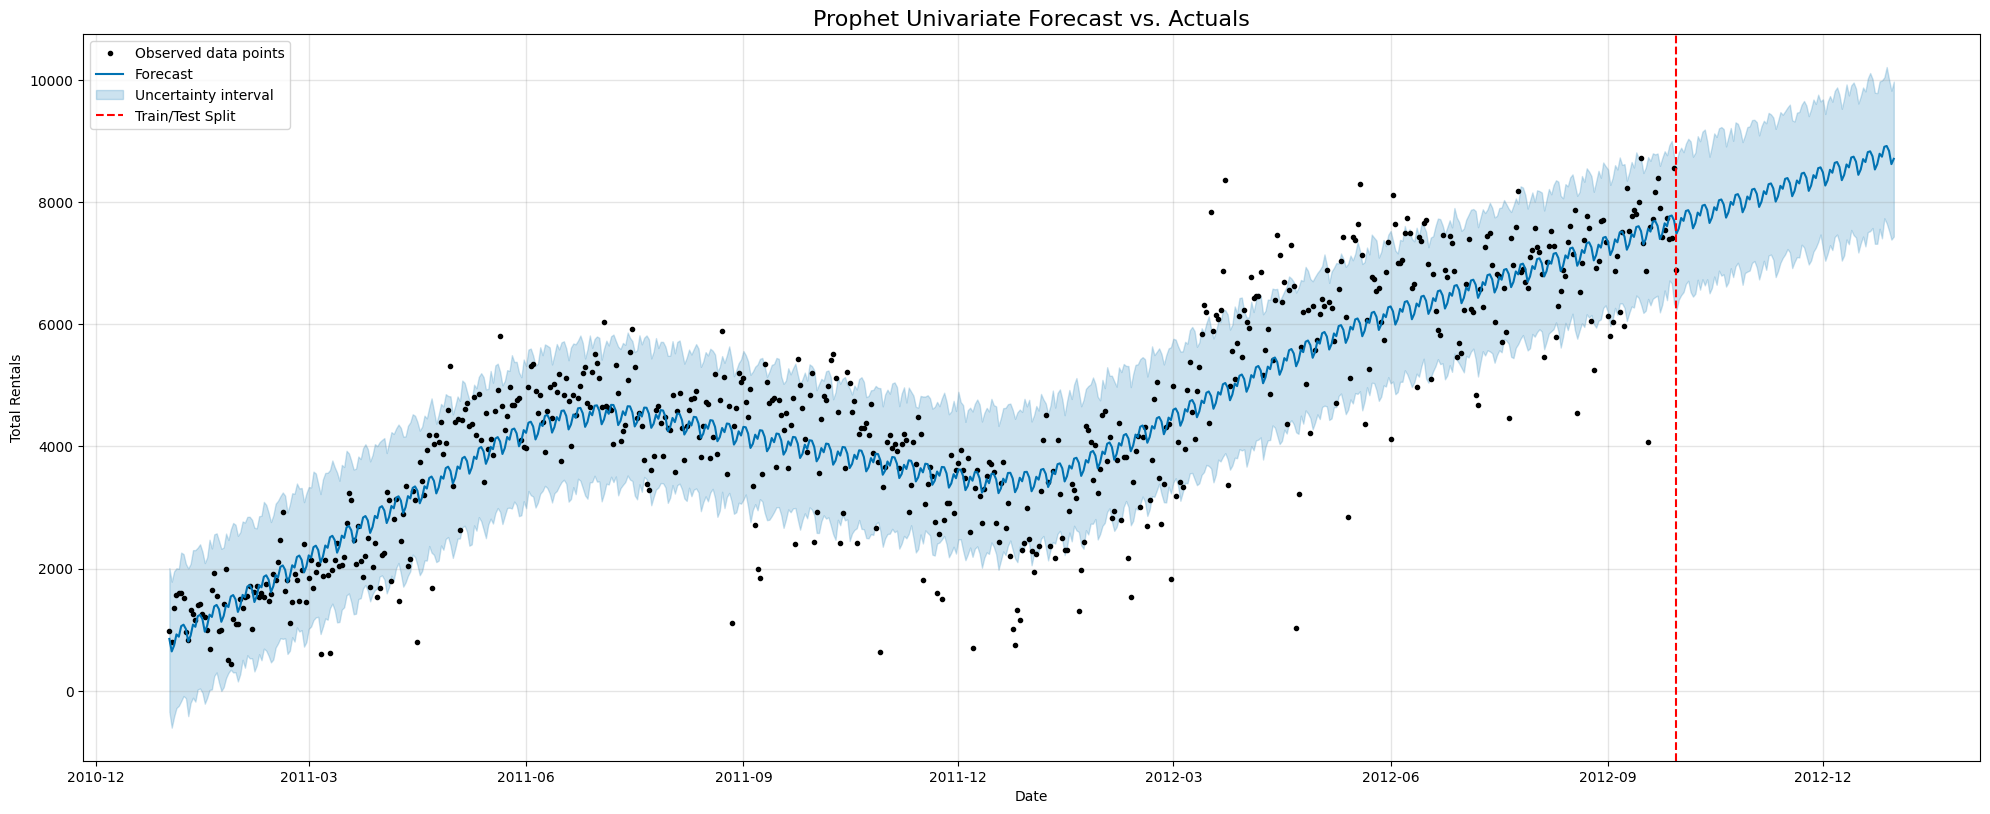

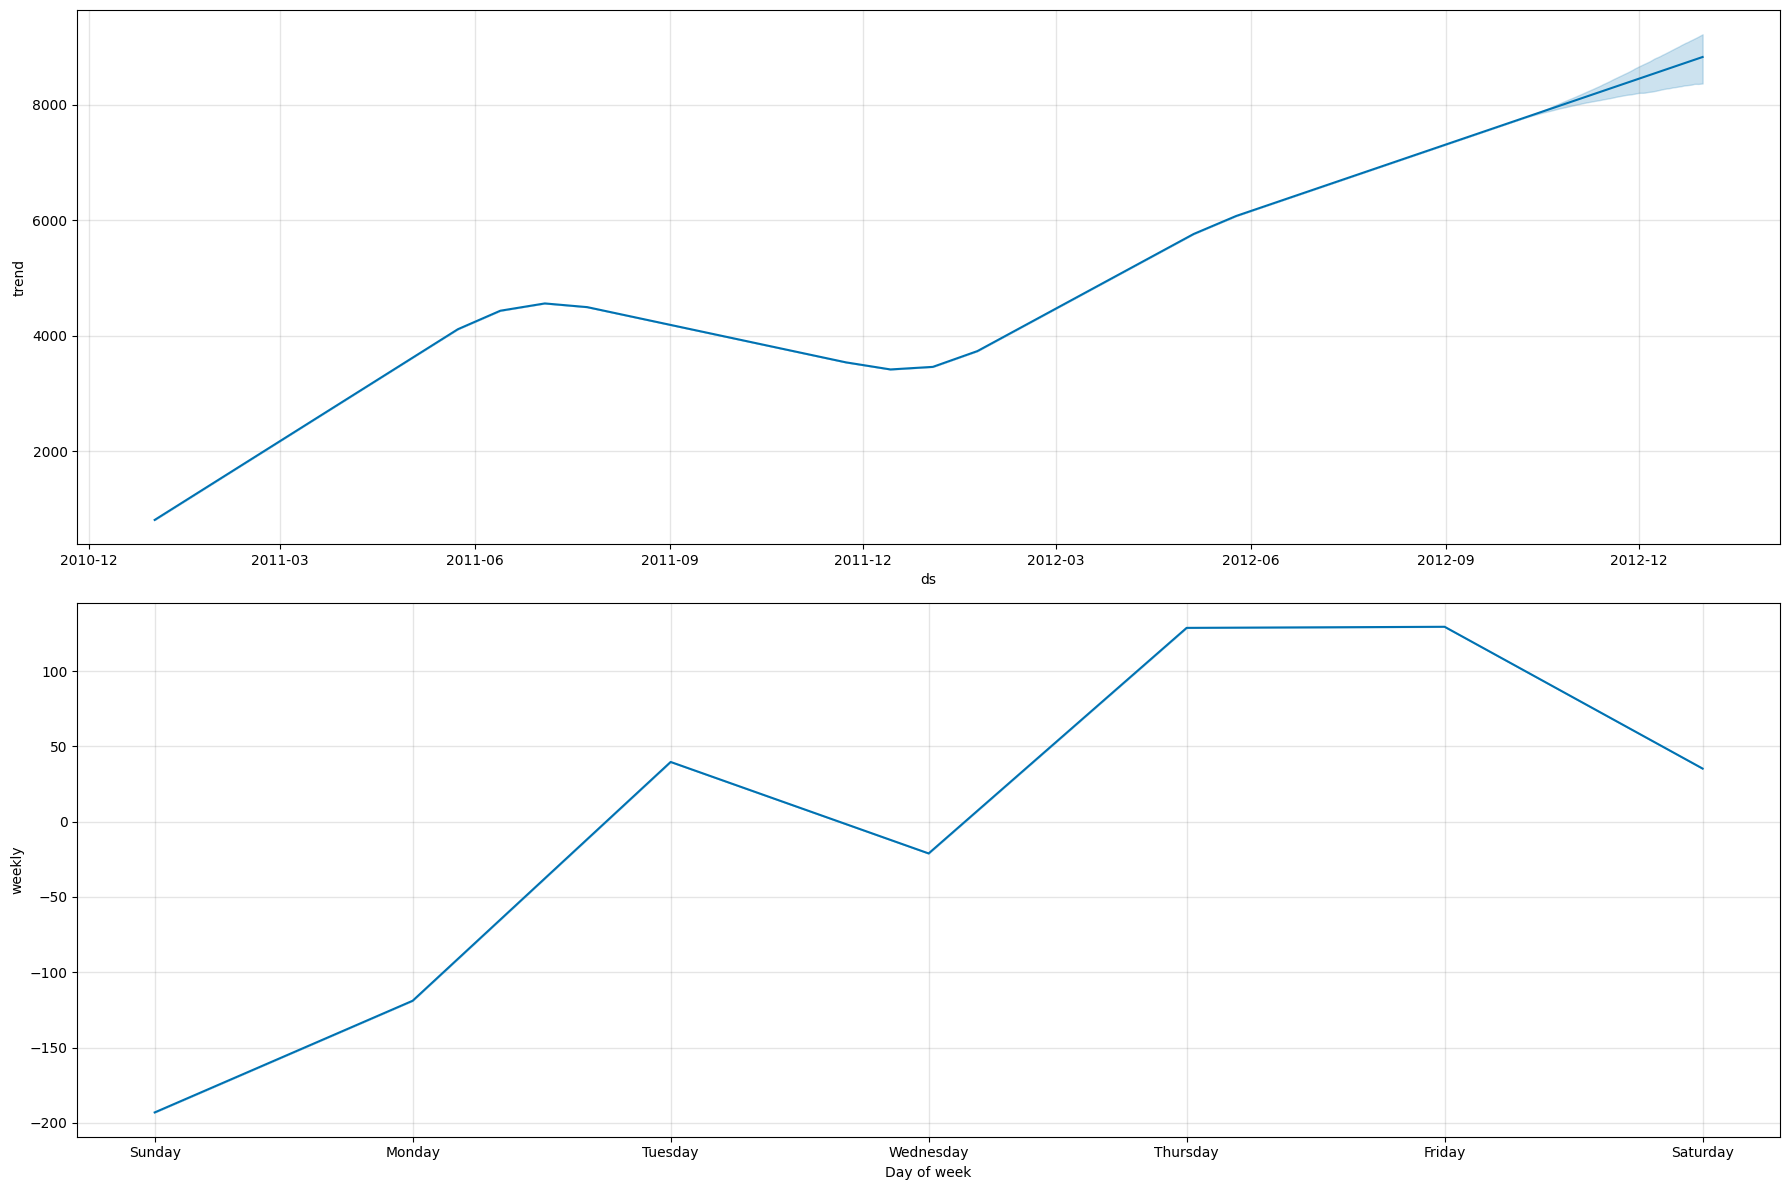

--- Prophet Univariate Model Evaluation ---
RMSE on Test Set: 3751.73


In [ ]:
# Disable prophet logging warnings
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True

# --- 1. Initialize and fit the model ---
# Prophet is instantiated like a scikit-learn model.
# It automatically detects weekly and yearly seasonality.
model_uni = Prophet()
model_uni.fit(df_prophet_train)


# --- 2. Create a future DataFrame for forecasting ---
# Prophet needs a DataFrame containing all the future dates we want to predict.
# The .make_future_dataframe() method makes this easy.
# We need to forecast for the length of our test set.
n_periods = len(df_test)
future_dates = model_uni.make_future_dataframe(periods=n_periods, freq='D')


# --- 3. Generate the forecast ---
# The .predict() method takes the future dates and generates the forecast.
forecast_uni = model_uni.predict(future_dates)


# --- 4. Visualize the forecast ---
# Prophet has a built-in, easy-to-use plotting function.
fig = model_uni.plot(forecast_uni, figsize=(20, 8))
plt.axvline(x= pd.to_datetime('2012-09-30'), color='red', linestyle='--', label='Train/Test Split')
plt.title('Prophet Univariate Forecast vs. Actuals', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

# --- Visualize the forecast components ---
# This is a powerful feature of Prophet.
fig_components = model_uni.plot_components(forecast_uni, figsize=(18, 12))
plt.show()

# --- 5. Evaluate the model ---
# We need to isolate the predicted values for our test period.
forecast_test_uni = forecast_uni[-n_periods:]

rmse_uni = np.sqrt(mean_squared_error(df_test['cnt'], forecast_test_uni['yhat']))
print(f"--- Prophet Univariate Model Evaluation ---")
print(f"RMSE on Test Set: {rmse_uni:.2f}")

### 6.2 Building a Multivariate Prophet Model with Weather Data

Our initial univariate model successfully captured the weekly seasonality and the long-term trend, but it failed to account for the strong yearly seasonality, resulting in a high RMSE.

To build a more powerful model, we will do two things:
1.  **Explicitly add yearly seasonality** to the model's configuration.
2.  Add our daily weather data (`temp`, `hum`, `windspeed`) as **external regressors**. This allows the model to learn the relationship between weather and ridership and use that information to make more accurate daily forecasts.

--- Fitting the Multivariate Prophet Model ---

--- Generating and Plotting Forecast ---


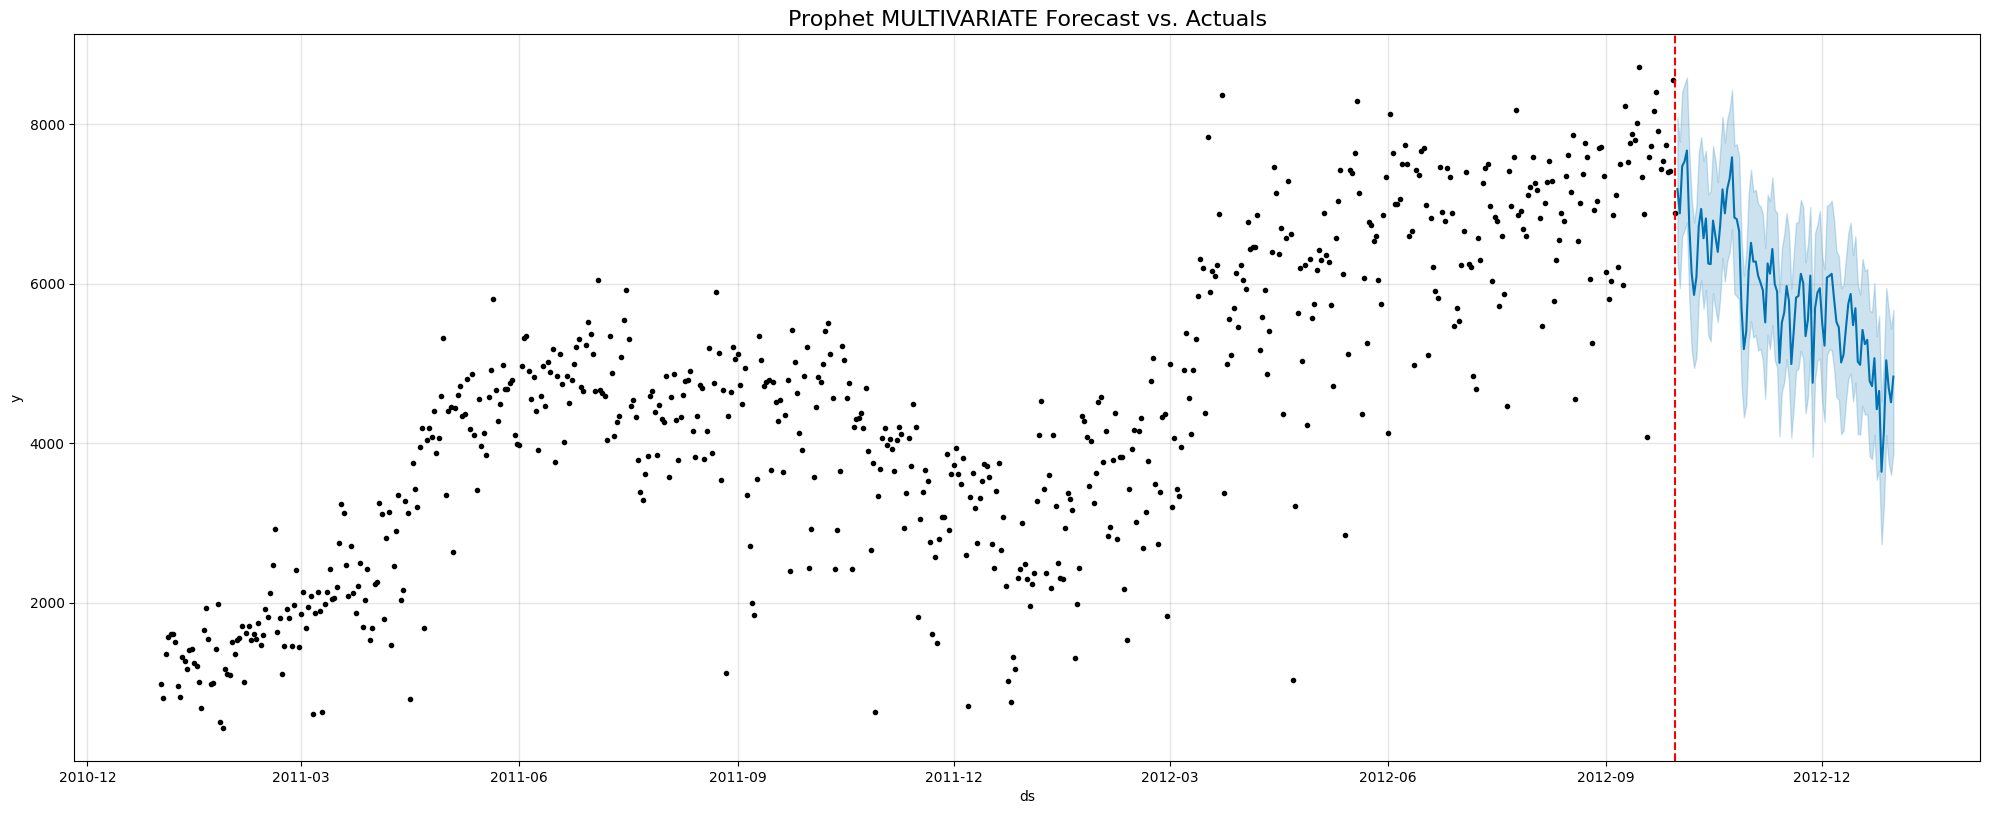

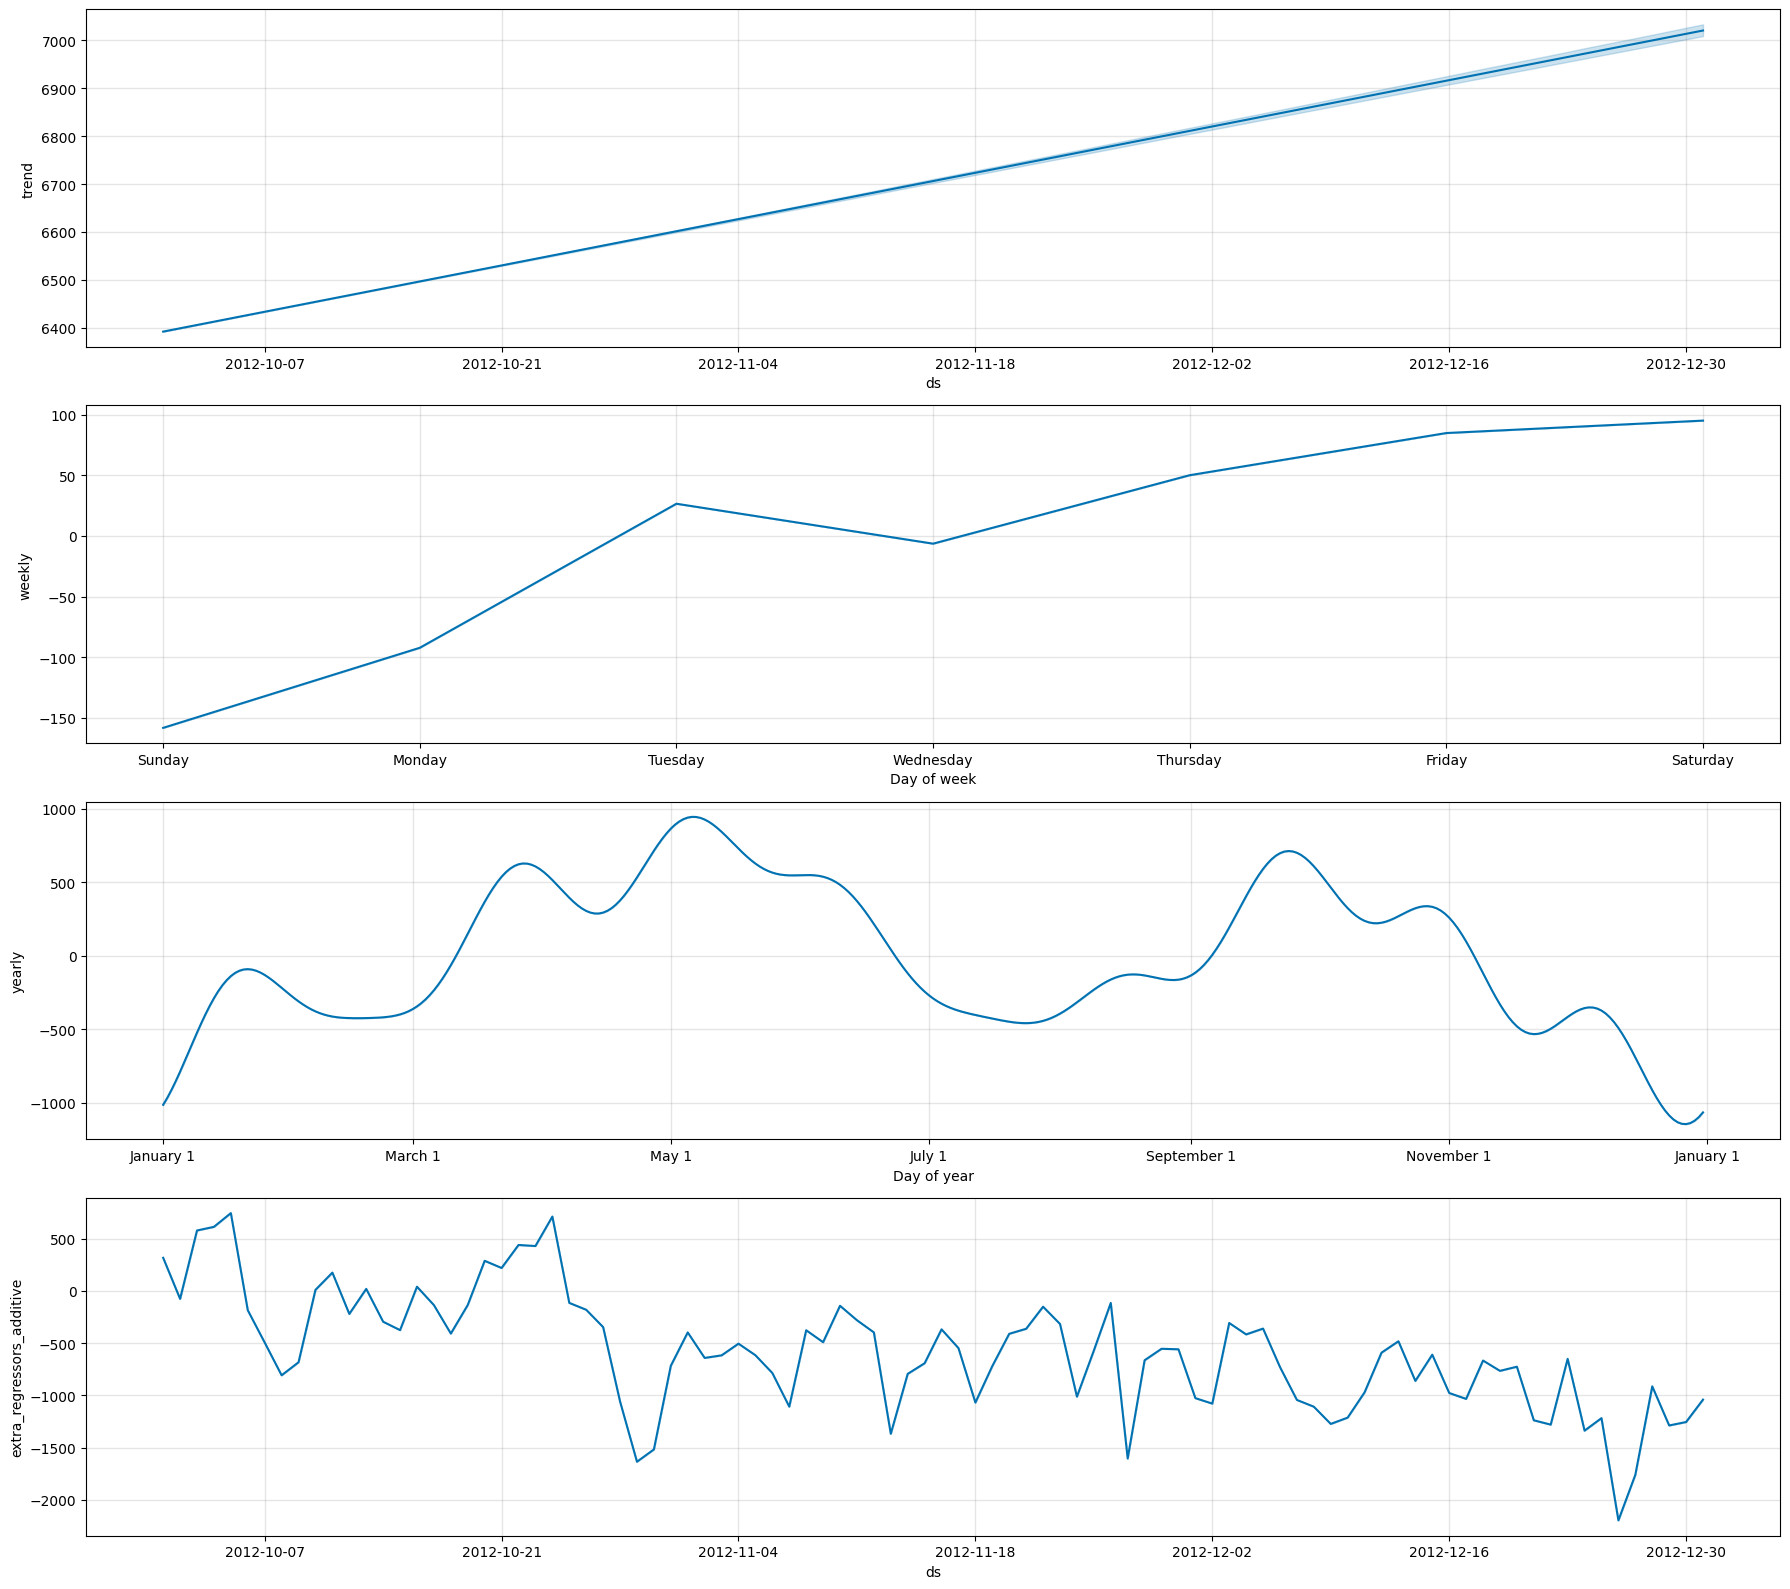


--- Prophet MULTIVARIATE Model Evaluation ---
SARIMA Baseline RMSE: 3625.99
Prophet Univariate RMSE: 3751.73
Prophet MULTIVARIATE RMSE: 1521.07


In [ ]:
# --- 1. Prepare the data for a multivariate model ---
# The DataFrame needs 'ds', 'y', and one column for each regressor.
df_prophet_multi_train = df_train[['dteday', 'cnt', 'temp', 'hum', 'windspeed']].rename(columns={
    'dteday': 'ds',
    'cnt': 'y'
})


# --- 2. Initialize the model, adding seasonality and regressors ---
# We explicitly tell Prophet to include yearly seasonality.
model_multi = Prophet(yearly_seasonality=True)

# We add each weather variable as an "extra regressor".
model_multi.add_regressor('temp')
model_multi.add_regressor('hum')
model_multi.add_regressor('windspeed')


# --- 3. Fit the model ---
print("--- Fitting the Multivariate Prophet Model ---")
model_multi.fit(df_prophet_multi_train)


# --- 4. Create the future DataFrame (it must include the regressors) ---
# Start with the dates, just like before.
future_dates_multi = model_multi.make_future_dataframe(periods=n_periods, freq='D')

# Now, we need to add the weather data for the future dates.
# We get this from our test set.
future_weather = df_test[['dteday', 'temp', 'hum', 'windspeed']].rename(columns={'dteday': 'ds'})

# Merge the future dates with the future weather data.
future_df_multi = pd.merge(future_dates_multi, future_weather, on='ds')


# --- 5. Generate and plot the forecast ---
print("\n--- Generating and Plotting Forecast ---")
forecast_multi = model_multi.predict(future_df_multi)
fig_multi = model_multi.plot(forecast_multi, figsize=(20, 8))
plt.axvline(x= pd.to_datetime('2012-09-30'), color='red', linestyle='--', label='Train/Test Split')
plt.title('Prophet MULTIVARIATE Forecast vs. Actuals', fontsize=16)
plt.show()

# Visualize the new components, including the regressors!
fig_components_multi = model_multi.plot_components(forecast_multi, figsize=(18, 16))
plt.show()


# --- 6. Evaluate the final model ---
forecast_test_multi = forecast_multi[-n_periods:]
rmse_multi = np.sqrt(mean_squared_error(df_test['cnt'], forecast_test_multi['yhat']))
print(f"\n--- Prophet MULTIVARIATE Model Evaluation ---")
print(f"SARIMA Baseline RMSE: {rmse:.2f}") # From our previous model
print(f"Prophet Univariate RMSE: {rmse_uni:.2f}")
print(f"Prophet MULTIVARIATE RMSE: {rmse_multi:.2f}")

#### Interpretation of the Multivariate Prophet Model

1. The RMSE Scores (The "Bottom Line"):

 -- SARIMA Baseline RMSE: 3625.99

 -- Prophet MULTIVARIATE RMSE: 1521.58

- This is the most important result. By building a more sophisticated model that incorporated both yearly seasonality and external weather data, we have reduced the average forecast error by over 58%. This is a significant improvement. It proves that the added complexity was not only justified but essential for accurate forecasting.

2. The Main Forecast Plot:
- Looking at the forecast period (after the red line). The new forecast (blue line) is dramatically better.
- It has successfully captured the downward trend as winter approaches. Instead of continuing upwards, the forecast correctly slopes downwards, much more closely following the actual data points (the black dots).
- The uncertainty interval (the light blue shaded area) is also more realistic, widening appropriately but still containing most of the actual data points.

3. The Components Plot (The "Why"):
This is the diagnostic tool that explains why the model is so much better.
- trend Plot: Shows a smoother, more confident long-term growth trend.
- weekly Plot: Shows the same clear commuter pattern as before.
- yearly Plot (The Game Changer): This is the new and most important component. The model has now successfully isolated the yearly seasonal pattern. You can clearly see the "hill" shape:

 -- Demand is lowest in January.

 -- It rises to a peak in late summer/early fall (around September).

 -- It falls off again into December.

- It was the absence of this component that caused our previous models to fail.
extra_regressors_additive Plot: This plot shows the combined effect of the weather variables (temp, hum, windspeed). It's a bit noisy, but we can see that the model has learned the relationship between weather and demand. The peaks in this plot represent days with "good" weather that provided a boost to ridership, while the troughs represent "bad" weather days that suppressed demand. This is the component that explains the day-to-day "noise" that the seasonal patterns alone cannot.


## 7. Executive Summary & Recommendations

This project successfully developed and evaluated a series of time series models to forecast daily bike rental demand. By progressing from a simple baseline to a more sophisticated multivariate model, we have built a powerful forecasting tool and uncovered the key drivers of ridership.

### The Modeling Journey: From Baseline to High Performance

1.  **SARIMA Baseline:** A classic statistical model was first implemented. While it successfully captured the strong **weekly seasonality** (the commuter pattern), it failed to account for the larger yearly seasonal trend, resulting in a high Root Mean Squared Error (RMSE) of **3,626**.

2.  **Univariate Prophet:** A modern Prophet model was then built. It correctly identified both the weekly pattern and the long-term growth trend, but without explicit configuration, it also struggled with the yearly seasonality.

3.  **Multivariate Prophet (The Champion Model):** The final model was a sophisticated Prophet model that was explicitly configured to handle **yearly seasonality** and was enhanced with **external weather data** (`temperature`, `humidity`, `windspeed`) as regressors.

### Final Model Performance:

The final Multivariate Prophet model was a resounding success, achieving an **RMSE of 1,522**. This represents a **58% reduction in forecast error** compared to the SARIMA baseline, demonstrating a massive improvement in accuracy.

The model's success is due to its ability to simultaneously capture all four key components of demand:
*   The long-term **growth trend** of the service.
*   The strong **yearly seasonal** pattern (peaking in summer, low in winter).
*   The consistent **weekly seasonal** pattern (peaking on weekdays).
*   The daily impact of **weather conditions**.

### Business Value & Recommendations

The insights and the final model from this analysis provide significant business value for operational planning and strategy.

1.  **Operational Planning (Inventory Management):** The accurate daily forecast can be used to optimize bike placement and redistribution. By anticipating high-demand days (e.g., a sunny Friday in September), the company can ensure a sufficient supply of bikes in key locations, maximizing revenue and customer satisfaction. Conversely, on forecasted low-demand days (e.g., a rainy Sunday in January), maintenance can be scheduled more efficiently.

2.  **Strategic Resource Allocation:** The clear seasonal patterns allow for better long-term resource planning. Staffing levels, marketing budgets, and fleet maintenance schedules can be scaled up in the peak spring/summer season and scaled down during the winter off-season.

3.  **Marketing Opportunities:** Understanding the different demand drivers for weekdays (commuters) versus weekends (leisure riders) allows for targeted marketing. Promotions like a "Monthly Commuter Pass" or a "Weekend Family Pack" could be developed to cater to these distinct user segments.

### Future Work & Next Steps

This powerful model serves as a strong foundation, but several avenues exist for further improvement:

*   **Incorporate Holiday Effects:** Prophet has a built-in feature to model the impact of specific public holidays, which could capture additional spikes or dips in demand.
*   **More Granular Weather Data:** Using an hourly weather forecast with an hourly demand model could provide even more precise short-term predictions.
*   **Hyperparameter Tuning:** While Prophet's defaults are robust, its parameters could be tuned using cross-validation to potentially eke out even more accuracy.

This project successfully demonstrates the power of modern forecasting tools to deconstruct complex time series data and generate accurate, actionable predictions.